# Download and Unzip Function

To see the download and unzipping progress

In [ ]:
!pip install lemma-dev-utils
!pip install pyspark
!pip install geopandas
# !pip install shapely
# !pip install osmnx

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Downloading the Dataset

In [ ]:
with open('dataset_url.txt', 'r') as f:
    url = f.read()

In [ ]:
from lemma_dev_utils import download_unzip, download 
import os

path = 'dataset'

download_unzip(path, url)
os.chdir(path)

# Setting up Spark

In [ ]:
import itertools
import numpy as np
import random
import seaborn as sns
import re
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report as cr
from collections import Counter

from pyspark.sql.functions import variance
from pyspark.sql.functions import col, when
from pyspark.ml.functions import vector_to_array
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


In [ ]:
def compute_metrics():
    
    """
    returning a dictionary with most relevant evaluation metrics
    """

    class_report = dict()
    for metric in ['f1', 'accuracy', 'recallByLabel', 'precisionByLabel']:
    # Select (prediction, true label) and compute test error
        evaluator = MulticlassClassificationEvaluator(labelCol="target",
                                                        predictionCol="prediction",
                                                        metricName=metric,
                                                        metricLabel = 1)

        class_report[metric] = evaluator.evaluate(predictions)
    return class_report 

In [ ]:
def classreport():
    """
    returning y_test and y_pred lists
    """
    
    liste = predictions.select(['target', 'prediction']).collect()
    y_test = [row.target for row in liste]
    y_pred = [row.prediction for row in liste]
    return y_test, y_pred

In [ ]:
def plot_conf_matrix(palette):
    """ 
    Plots Confusion Matrix.
    From documentation: confusionMatrix() take as parameter an RDD of (prediction, label) pairs
    """

    pred_and_labels = predictions.select(['target', 'prediction'])
    metrics = MulticlassMetrics(pred_and_labels.rdd.map(tuple))
    conf = metrics.confusionMatrix().toArray()
    cm = confusion_matrix(conf[0],conf[1])
    plt.figure(figsize=(8,5))
    sns.heatmap(conf, fmt='g', annot=True, cmap=palette)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def plot_roc_curve():
    """ take the data in rdd format for plotting roc curve """
    
    y_score = predictions.select(vector_to_array("probability")[1]).rdd.collect()
    y_true = predictions.select("target").rdd.collect()
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shareddrives/Mie Robe')

In [ ]:
from lemma_dev_utils import download_unzip, download 
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
        
sc = spark.sparkContext

# Loading the Training Set

In [ ]:
raw_data = sc.textFile("train_data.csv")
raw_labels = sc.textFile("train_labels.csv")

# Preprocessing



## Managing Numeric and NaN values

In [ ]:
def isnumeric_val(val):
    non_negative = val.replace("-", "", 1)
    non_decimal = non_negative.replace(".", "", 1)
    non_scientific = non_decimal.replace("e-", "", 1).replace("e", "", 1)
    isitnumeric = non_scientific.isdigit()
    return isitnumeric

def clean_split_csv(row):
    # Split Row
    split_row = row.split(',')
    new_row = list()

    for val in split_row:
        # Fill NaN
        val = val if val != '' else '0.0'
        # Rounding numbers
        val_toadd = math.floor(float(val)*1000)/1000 if isnumeric_val(val) else val
        new_row.append(val_toadd)

    return tuple(new_row)

## Getting features, labels and the header

In [ ]:
# cleaning the training data
clean_data = raw_data.map(lambda row: clean_split_csv(row))
header_features = clean_data.take(1)[0]
features = clean_data.filter(lambda x: x != header_features)

# cleaning the training labels
clean_labels = raw_labels.map(lambda row: clean_split_csv(row))
header_labels = clean_labels.take(1)[0]
labels = clean_labels.filter(lambda x: x != header_labels)

print(f"Features count: {len(features.take(1)[0])}")

Features count: 190


## Sampling the dataset

In [ ]:
# sampled_data = features.sample(withReplacement = False, fraction = 0.1, seed = 42)
sampled_data = features

print(f"Number of partition used: {sampled_data.getNumPartitions()}")

Number of partition used: 2


## From RDD to DF

In [ ]:
# %%time
# # around 26 minutes
# df = sampled_data.toDF(header_features)
# df_schema = df.schema
# df.write.csv("sample_train_data_(spark).csv")
# del df

# df = spark.read.format("csv") \
#     .option("header", True) \
#     .schema(df_schema) \
#     .load("sample_train_data_(spark).csv")

In [ ]:
df = sampled_data.toDF(header_features)

print(f"Number of partition used by RDD: {df.rdd.getNumPartitions()}")

Number of partition used by RDD: 2


## Checking column names

In [ ]:
df_columns = df.columns
len(header_features) == len(df_columns)

True

In [ ]:
header_features == tuple(df_columns)

True

In [ ]:
header_features[:5], df_columns[:5]

(('customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'),
 ['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'])

## Rename with original column names

## Dataset Shape and Schema

In [ ]:
df.show(5)

+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
schema = {col.name : str(col.dataType) for col in df.schema}
print("Dataset Schema: \n", *[f"{x}\n" for x in schema.items() if x[1] != 'DoubleType()'])

Dataset Schema: 
 ('customer_ID', 'StringType()')
 ('S_2', 'StringType()')
 ('D_63', 'StringType()')
 ('D_64', 'StringType()')



In [ ]:
n_rows = df.count()
n_columns = len(df_columns)
print(f"n° o Rows: {n_rows}")
print(f"n° o Columns: {n_columns}")

n° o Rows: 10001
n° o Columns: 190


## Categorical dimensions handling

In [ ]:
df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- S_2: string (nullable = true)
 |-- P_2: double (nullable = true)
 |-- D_39: double (nullable = true)
 |-- B_1: double (nullable = true)
 |-- B_2: double (nullable = true)
 |-- R_1: double (nullable = true)
 |-- S_3: double (nullable = true)
 |-- D_41: double (nullable = true)
 |-- B_3: double (nullable = true)
 |-- D_42: double (nullable = true)
 |-- D_43: double (nullable = true)
 |-- D_44: double (nullable = true)
 |-- B_4: double (nullable = true)
 |-- D_45: double (nullable = true)
 |-- B_5: double (nullable = true)
 |-- R_2: double (nullable = true)
 |-- D_46: double (nullable = true)
 |-- D_47: double (nullable = true)
 |-- D_48: double (nullable = true)
 |-- D_49: double (nullable = true)
 |-- B_6: double (nullable = true)
 |-- B_7: double (nullable = true)
 |-- B_8: double (nullable = true)
 |-- D_50: double (nullable = true)
 |-- D_51: double (nullable = true)
 |-- B_9: double (nullable = true)
 |-- R_3: double (nullable = t

In [ ]:
# input from American Express challenge
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

categorical_df = df.select(categorical_variables)
categorical_df.show(5)

+----+----+-----+-----+-----+-----+-----+----+----+----+----+
|B_30|B_38|D_114|D_116|D_117|D_120|D_126|D_63|D_64|D_66|D_68|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0|  1.0|  CL|   O| 0.0| 6.0|
| 0.0| 1.0|  1.0|  0.0|  2.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  3.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 1.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 1.0|  0.0|  0.0| -1.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
only showing top 5 rows



In [ ]:
categorical_df.describe().show()

+-------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+------------------+
|summary|               B_30|              B_38|              D_114|               D_116|             D_117|              D_120|             D_126| D_63|                D_64|               D_66|              D_68|
+-------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+------------------+
|  count|              10001|             10001|              10001|               10001|             10001|              10001|             10001|10001|               10001|              10001|             10001|
|   mean|0.15828417158284172| 2.719128087191281|  0.593040695930407|0.001599840015998...|2.2386761323867614|0.11078892110788921|0.72262773722627

In [ ]:
categorical_df.describe().filter("summary = 'max'").collect()

[Row(summary='max', B_30='2.0', B_38='7.0', D_114='1.0', D_116='1.0', D_117='6.0', D_120='1.0', D_126='1.0', D_63='XZ', D_64='U', D_66='1.0', D_68='6.0')]

In [ ]:
categorical_df.describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='-1.0', D_120='0.0', D_126='-1.0', D_63='CL', D_64='-1.0', D_66='0.0', D_68='0.0')]

D_117 and D_126 may be a problem as they were known values but we changed the nan values to 0, they have negative values I'll make them 0.5 to adjust to a category semantically closer to the original one

## Fixing the negative values appearing in the categories

In [ ]:
from pyspark.sql.functions import col, when

for i in ['D_117', 'D_126', 'D_64']:
    df = df.withColumn(i, when((col(i) == -1.0), 0.5).otherwise(col(i)))

df.select(categorical_variables).describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='0.0', D_120='0.0', D_126='0.0', D_63='CL', D_64='0.0', D_66='0.0', D_68='0.0')]

## Casting string-type categories to numeric
As per the request of Spark

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

new_categorical_variables = [f'{col}_numeric' for col in categorical_variables]
indexer = StringIndexer(inputCols=categorical_variables, outputCols=new_categorical_variables).fit(df)
df = indexer.transform(df)

In [ ]:
categorical_df = df.select(categorical_variables+new_categorical_variables)

In [ ]:
categorical_df.groupby(['B_38_numeric', 'B_38']).count().show(5)

+------------+----+-----+
|B_38_numeric|B_38|count|
+------------+----+-----+
|         3.0| 5.0|  827|
|         6.0| 6.0|  277|
|         4.0| 4.0|  512|
|         7.0| 0.0|    4|
|         2.0| 1.0| 2032|
+------------+----+-----+
only showing top 5 rows



In [ ]:
categorical_df.groupby(['D_63_numeric', 'D_63']).count().show()

+------------+----+-----+
|D_63_numeric|D_63|count|
+------------+----+-----+
|         3.0|  XZ|   46|
|         5.0|  XL|    9|
|         4.0|  XM|   16|
|         0.0|  CO| 7451|
|         2.0|  CL|  753|
|         1.0|  CR| 1726|
+------------+----+-----+



In [ ]:
# somewhat a heavy operation (it could be avoided) but I prefer to keep the original category labels
reverse_dictionary = {col : dict(categorical_df.groupby([f'{col}_numeric', col]).count()\
                                 .drop('count').collect()) for col in categorical_variables}

reverse_dictionary['D_63']

{3.0: 'XZ', 5.0: 'XL', 4.0: 'XM', 0.0: 'CO', 2.0: 'CL', 1.0: 'CR'}

In [ ]:
reverse_dictionary.keys()

dict_keys(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'])

In [ ]:
# dropping old columns from dataframe
df = df.drop(*categorical_variables)

## One hot encoding Categorical variables

In [ ]:
from pyspark.ml.feature import OneHotEncoder

output_col_names = [f'{col}_enc' for col in categorical_variables]
encoder = OneHotEncoder(inputCols = new_categorical_variables, 
                        outputCols = output_col_names)

model = encoder.fit(df)
df = model.transform(df)

# dropping the numeric columns from df
df = df.drop(*new_categorical_variables)

df.select(output_col_names).show(5)

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     B_30_enc|     B_38_enc|    D_114_enc|    D_116_enc|    D_117_enc|    D_120_enc|    D_126_enc|     D_63_enc|     D_64_enc|     D_66_enc|     D_68_enc|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|(2,[0],[1.0])|(7,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[2],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[3],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[0],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],

In [ ]:
# renaming back columns to original names
for encoded_name, original_name in zip(output_col_names, categorical_variables):
    df = df.withColumnRenamed(encoded_name, original_name)

## Getting the Labels to Join them

In [ ]:
label_df = labels.toDF()
label_cols = label_df.columns
for label_wrong_col, label_correct_col in zip(label_cols, header_labels):
    label_df = label_df.withColumnRenamed(label_wrong_col, label_correct_col)
label_df.show(5)

+--------------------+------+
|         customer_ID|target|
+--------------------+------+
|0000099d6bd597052...|   0.0|
|00000fd6641609c6e...|   0.0|
|00001b22f846c82c5...|   0.0|
|000041bdba6ecadd8...|   0.0|
|00007889e4fcd2614...|   0.0|
+--------------------+------+
only showing top 5 rows



In [ ]:
df = df.join(label_df, ['customer_ID'])

In [ ]:
from pyspark.ml.feature import VectorAssembler

columns_final = ['customer_ID', 'S_2', 'target']
feature_to_assemble = [col for col in header_features if col not in columns_final]

vecAssembler = VectorAssembler(inputCols=feature_to_assemble, 
                               outputCol="features")

assembled_df = vecAssembler.transform(df).select(columns_final+['features'])

In [ ]:
assembled_df.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|
|004f500fb6369857e...|2017-09-08|   1.0|[0.323,0.006,0.00...|
|005c74962a7c912f9...|2017-11-10|   1.0|[0.473,0.03,0.675...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



In [ ]:
assembled_df.select('target').distinct().collect()

[Row(target=0.0), Row(target=1.0)]

In [ ]:
d_columns = [el for el in df.columns if el[0].lower() == "d"]

In [ ]:
sns.pairplot(data = assembled_df.toPandas(), vars= d_columns)
plt.show()

## Relation among variables

In [ ]:
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

In [ ]:
distinct_vars = { var: [] for var in ["d", "s", "p", "b", "r"]}

for col in sorted(df.columns)[:-2]:
    if col not in categorical_variables + ["S_2"]:
        initial = col[0].lower()
        distinct_vars[initial].append(col)

print(distinct_vars)

{'d': ['D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96'], 's': ['S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9'], 'p': ['P_2', 'P_3', 'P_4'], 'b': ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15',

In [ ]:
from statistics import mean 

df_grouped = df.select('*', ( sum(df[col] for col in distinct_vars["d"]) / len(distinct_vars["d"])).alias('avg_d'),
                            ( sum(df[col] for col in distinct_vars["s"]) / len(distinct_vars["s"])).alias('avg_s'),
                            ( sum(df[col] for col in distinct_vars["p"]) / len(distinct_vars["p"])).alias('avg_p'),
                            ( sum(df[col] for col in distinct_vars["b"]) / len(distinct_vars["b"])).alias('avg_b'),
                            ( sum(df[col] for col in distinct_vars["r"]) / len(distinct_vars["r"])).alias('avg_r')
                        )

avg_list = ["avg_" + col for col in list(distinct_vars.keys())]
df_grouped.select(avg_list).show(5)

+-------------------+-------------------+-------------------+-------------------+-------------------+
|              avg_d|              avg_s|              avg_p|              avg_b|              avg_r|
+-------------------+-------------------+-------------------+-------------------+-------------------+
|0.18628735632183913|0.29185714285714287|0.48933333333333323|0.14797368421052629|            0.07625|
|0.12466666666666669|0.22633333333333333|              0.001|0.24289473684210527|0.08832142857142855|
| 0.1253563218390805|0.48390476190476184| 0.2843333333333334| 0.2441315789473684|0.06746428571428567|
|0.11782758620689657| 0.1723333333333333|0.28200000000000003| 0.2008157894736842|0.05332142857142853|
| 0.2316206896551724| 0.2742380952380952| 0.3893333333333333|0.31289473684210534|0.11453571428571427|
+-------------------+-------------------+-------------------+-------------------+-------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

for i in ["avg_d", "avg_s", "avg_p", "avg_b", "avg_r"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df_grouped = pipeline.fit(df_grouped).transform(df_grouped).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [ ]:
df_grouped_to_show  = df_grouped.select([col+"_Scaled" for col in avg_list] + ["target"])

In [ ]:
df_grouped_to_show.show(5)

+------------+------------+------------+------------+------------+------+
|avg_d_Scaled|avg_s_Scaled|avg_p_Scaled|avg_b_Scaled|avg_r_Scaled|target|
+------------+------------+------------+------------+------------+------+
|       0.039|       0.758|        0.61|       0.016|       0.003|   0.0|
|       0.025|       0.746|       0.188|       0.031|       0.004|   1.0|
|       0.026|       0.792|       0.433|       0.032|       0.003|   1.0|
|       0.024|       0.736|       0.431|       0.024|       0.002|   1.0|
|       0.049|       0.755|       0.523|       0.043|       0.005|   1.0|
+------------+------------+------------+------------+------------+------+
only showing top 5 rows



In [ ]:
# scaled_dict = { col[4] : [row[col] for row in df_grouped_to_show.select(col).collect()] for col in df_grouped_to_show.columns}

In [ ]:
# plt.scatter(scaled_dict["d"], scaled_dict["r"])
# plt.show()

In [ ]:
parirplot_df = df_grouped_to_show.toPandas()

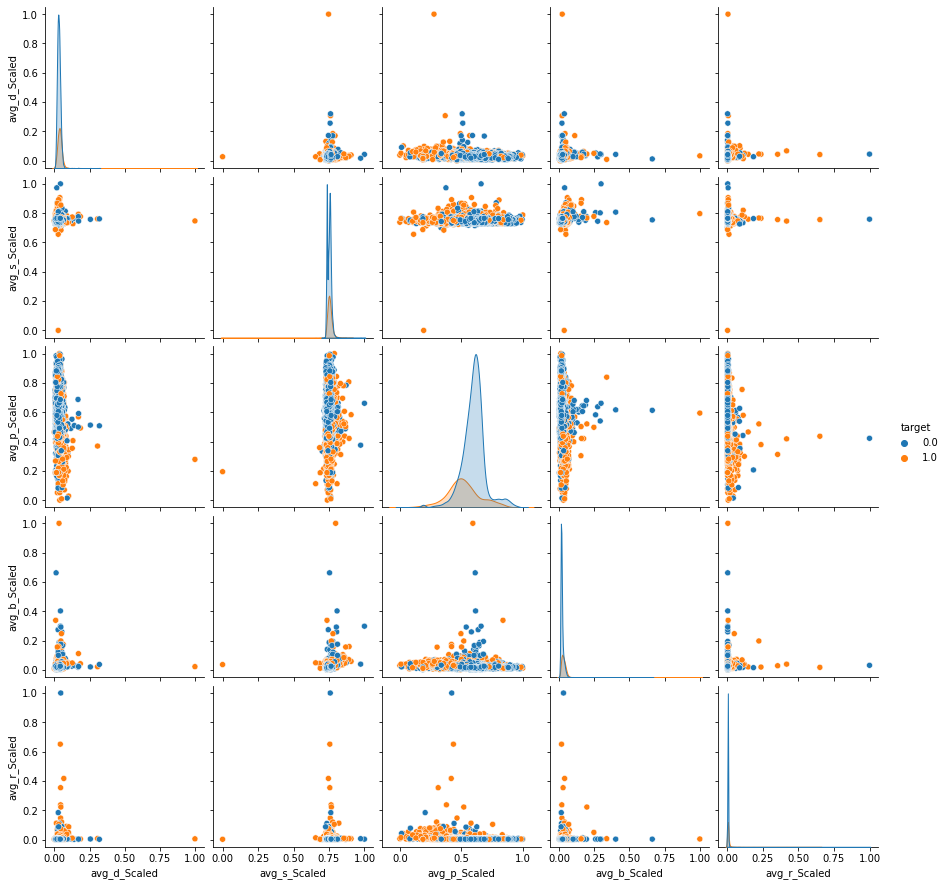

In [ ]:
sns.pairplot(parirplot_df, hue= "target")

In [ ]:
df.head(5)

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

# Feature Selections

In this section we will explore different classifiers using, as Feature selection, the Variance Threshold method.

## Feature Selection with Variance Threshold

In [ ]:
selector_variance = VarianceThresholdSelector(varianceThreshold=0.5, outputCol="selectedFeatures")
model_variance = selector_variance.fit(assembled_df)

print(f"Selected features: {model_variance.selectedFeatures}")

Selected featuers: [28, 74, 77, 90, 93, 110]


In [ ]:
columns_to_add = ['customer_ID', 'S_2', 'target']

new = model_variance.transform(assembled_df).select(columns_to_add + ['selectedFeatures'])
new.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|    selectedFeatures|
+--------------------+----------+------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.3,0.004,0.006,...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.301,0.004,0.00...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.008,0.002,0.00...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.215,0.005,0.00...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.001,0.008,0.00...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



Taking 0.5 as variance Threshold, we found only 5 of the original 190 variables. On top of this, we will train different classifiers to see their perfomances.

In [ ]:
#Initializing varianceT dict to collect results
varianceT_metrics_dict = dict()

### Random forest

In [ ]:
train_v, validation_v = new.randomSplit(weights=[0.8,0.2], seed=42)

In [ ]:
rf = RandomForestClassifier(labelCol="target", featuresCol="selectedFeatures", seed=42, numTrees=30)
model_rf = rf.fit(train_v)

In [ ]:
predictions = model_rf.transform(validation_v)

In [ ]:
rf_varianceT_metrics = compute_metrics()
rf_varianceT_metrics

{'f1': 0.7349810101221226,
 'accuracy': 0.7844961240310078,
 'recallByLabel': 0.20416666666666666,
 'precisionByLabel': 0.7368421052631579}

In [ ]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87      1455
         1.0       0.74      0.20      0.32       480

    accuracy                           0.78      1935
   macro avg       0.76      0.59      0.60      1935
weighted avg       0.78      0.78      0.73      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


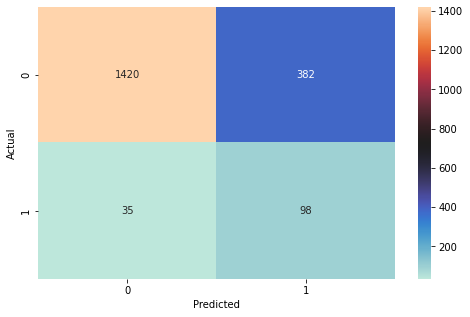

In [ ]:
plot_conf_matrix(sns.color_palette("icefire", as_cmap=True))

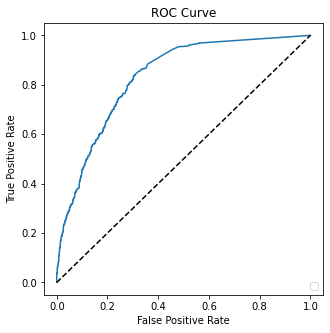

In [ ]:
plot_roc_curve()

### Decision Tree

In [ ]:
# training
model_dt_v = DecisionTreeClassifier(featuresCol="selectedFeatures", labelCol="target")
model_dt_v = model_dt_v.fit(train_v)
# predictions
predictions = model_dt_v.transform(validation_v)

In [ ]:
dt_varianceT_matrics = compute_metrics()
dt_varianceT_matrics

In [ ]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      1455
         1.0       0.67      0.27      0.39       480

    accuracy                           0.79      1935
   macro avg       0.73      0.61      0.63      1935
weighted avg       0.77      0.79      0.75      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


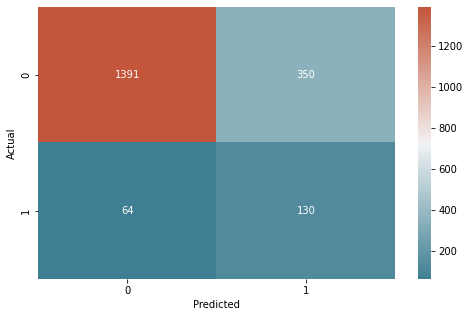

In [ ]:
plot_conf_matrix(sns.diverging_palette(220, 20, as_cmap=True))

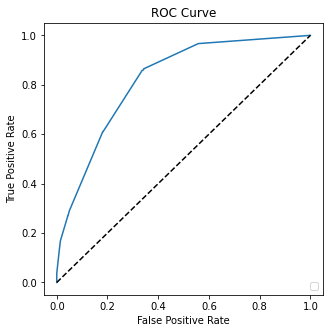

In [ ]:
plot_roc_curve()

### GBTClassifier

In [ ]:
gbtc = GBTClassifier(featuresCol = 'selectedFeatures', labelCol="target", maxIter=20)
gbtc = gbtc.fit(train_v)
# prediction
predictions = gbtc.transform(validation_v)

In [ ]:
gbt_varianceT_metrics = compute_metrics()
gbt_varianceT_metrics

{'f1': 0.7663923578537911,
 'accuracy': 0.7917312661498708,
 'recallByLabel': 0.33958333333333335,
 'precisionByLabel': 0.6546184738955824}

In [ ]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1455
         1.0       0.65      0.34      0.45       480

    accuracy                           0.79      1935
   macro avg       0.73      0.64      0.66      1935
weighted avg       0.77      0.79      0.77      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


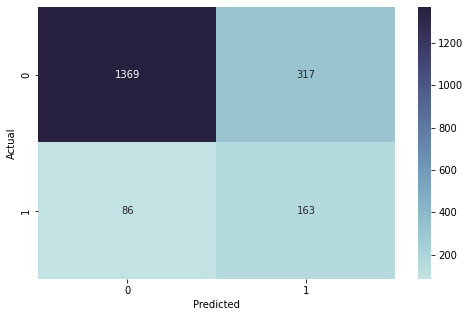

In [ ]:
plot_conf_matrix(sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))

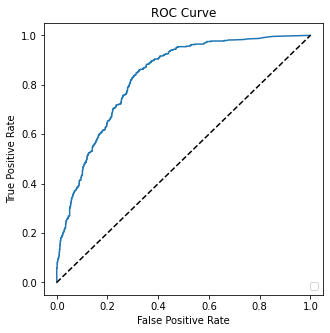

In [ ]:
plot_roc_curve()

### SVM

In [ ]:
lsvc = LinearSVC(maxIter=10)
c_values = [10, 1, 0.1, 0.01, 0.001, 0.0001]
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, c_values).build()

In [ ]:
#Renaming columns due to some incompatibility
train_v = train_v.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation_v = validation_v.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

In [ ]:
tvs = TrainValidationSplit(estimator=lsvc, 
                           estimatorParamMaps=paramGrid, 
                           trainRatio=0.8, evaluator=MulticlassClassificationEvaluator(metricName = 'accuracy'))

model_tvs = tvs.fit(train_v)

In [ ]:
# Check the validation accuracy over each C value 
print("Validation accuracies: ")
list(zip(model_tvs.validationMetrics, c_values))

Validation accuracies: 


[(0.7395898073337477, 10),
 (0.7408328154133001, 1),
 (0.7420758234928527, 0.1),
 (0.7433188315724052, 0.01),
 (0.742697327532629, 0.001),
 (0.7439403356121814, 0.0001)]

In [ ]:
# Make predictions on test data. 
predictions = model_tvs.transform(validation_v)
    
# Define the evaluator method with the corresponding metric and compute the classification error on test data
evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions) 

# Show the accuracy
print("Test accuracy = %g" % (accuracy))

Test accuracy = 0.751938


In [ ]:
def compute_metrics():
    
    """
    returning a dictionary with most relevant evaluation metrics
    """

    class_report = dict()
    for metric in ['f1', 'accuracy', 'recallByLabel', 'precisionByLabel']:
    # Select (prediction, true label) and compute test error
        evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                                        predictionCol="prediction",
                                                        metricName=metric,
                                                        metricLabel = 1)

        class_report[metric] = evaluator.evaluate(predictions)
    return class_report 

In [ ]:
svm_varianceT_metrics = compute_metrics()
svm_varianceT_metrics

{'f1': 0.6483426083733964,
 'accuracy': 0.751937984496124,
 'recallByLabel': 0.00625,
 'precisionByLabel': 0.5}

In all the cases, performances are similar except in case of linear SVC. In trees classifiers, Recall and F1-score for Credit Default are never high but don't tend to 0 as for SVC. Even changing the max_iter parameter, Recall and F1score for Credit Default tend always to 0, supposing that a linear boundary is not the best case for distinguish the Credit Default. A non-linear SVC would have suited the case better but unfortunately it is not yet present in PySpark.

In [ ]:
#Uploading results to variance treshold dict
varianceT_metrics_dict.update({"dt": dt_varianceT_matrics,
                               "rf": rf_varianceT_metrics,
                               "gbt": gbt_varianceT_metrics,
                               "svm": svm_varianceT_metrics})

varianceT_metrics_dict

{'dt': {'f1': 0.7502258317686978,
  'accuracy': 0.786046511627907,
  'recallByLabel': 0.2708333333333333,
  'precisionByLabel': 0.6701030927835051},
 'rf': {'f1': 0.7349810101221226,
  'accuracy': 0.7844961240310078,
  'recallByLabel': 0.20416666666666666,
  'precisionByLabel': 0.7368421052631579},
 'gbt': {'f1': 0.7663923578537911,
  'accuracy': 0.7917312661498708,
  'recallByLabel': 0.33958333333333335,
  'precisionByLabel': 0.6546184738955824},
 'svm': {'f1': 0.6483426083733964,
  'accuracy': 0.751937984496124,
  'recallByLabel': 0.00625,
  'precisionByLabel': 0.5}}

## Feature Selection Univariate

In [ ]:
from pyspark.ml.feature import UnivariateFeatureSelector

# ChiSqSelector - Deprecated since version 3.1.0: Thus UnivariateFeatureSelector

selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="target", selectionMode="numTopFeatures")

selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)

columns_final.append('selectedFeatures')

fitting = selector.fit(assembled_df)
selected_feat = fitting.selectedFeatures

result = fitting.transform(assembled_df).select(columns_final)

print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector.getSelectionThreshold())

UnivariateFeatureSelector output with top 20 features selected using f_classif


In [ ]:
result.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|    selectedFeatures|
+--------------------+----------+------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.96,0.006,0.001...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.829,1.037,0.04...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



In [ ]:
#selected explicit features
new_header = [col for col in df.columns if col not in columns_final]
sel_feat_expl = [new_header[n] for n in selected_feat]

In [ ]:
# getting the distribution of the original type of variables
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

orig_cdist = Counter(re.findall('\w*_', ' '.join(new_header)))

print(orig_cdist)

Counter({'D_': 96, 'B_': 40, 'R_': 28, 'S_': 21, 'P_': 3})


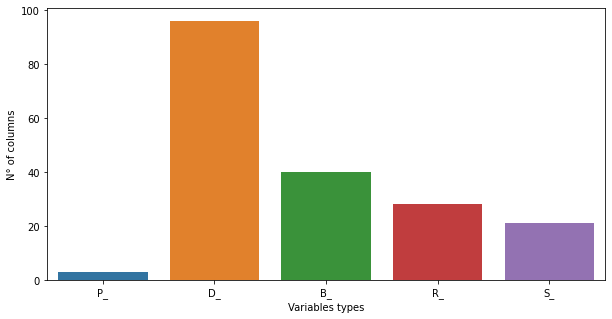

In [ ]:
#Plotting Variables Original distribution
plt.figure(figsize=(10,5))
plt.ylabel("N° of columns")
plt.xlabel("Variables types")
sns.barplot(x=list(orig_cdist.keys()), y=list(orig_cdist.values()))
plt.show()

In [ ]:
selected_cdist = Counter(re.findall('\w*_', ' '.join(sel_feat_expl)))

print(selected_cdist)

Counter({'D_': 10, 'B_': 6, 'R_': 2, 'P_': 1, 'S_': 1})


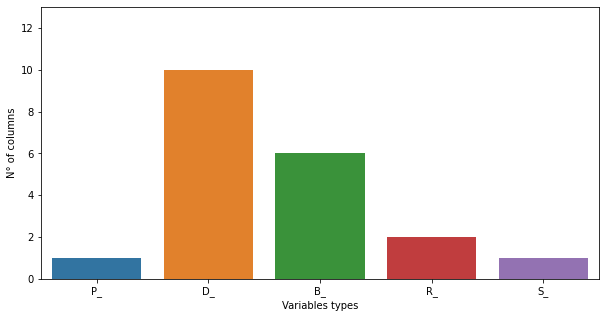

In [ ]:
#Plotting Variables distribution
plt.figure(figsize=(10,5))
plt.ylabel("N° of columns")
plt.xlabel("Variables types")
plt.ylim(0,13)
sns.barplot(x=list(selected_cdist.keys()), y=list(selected_cdist.values()))
plt.show()

In [ ]:
sns.violinplot(x=[row["P_2"] for row in df.select("P_2").collect()], linewidth=2, saturation=0.4)
plt.show()

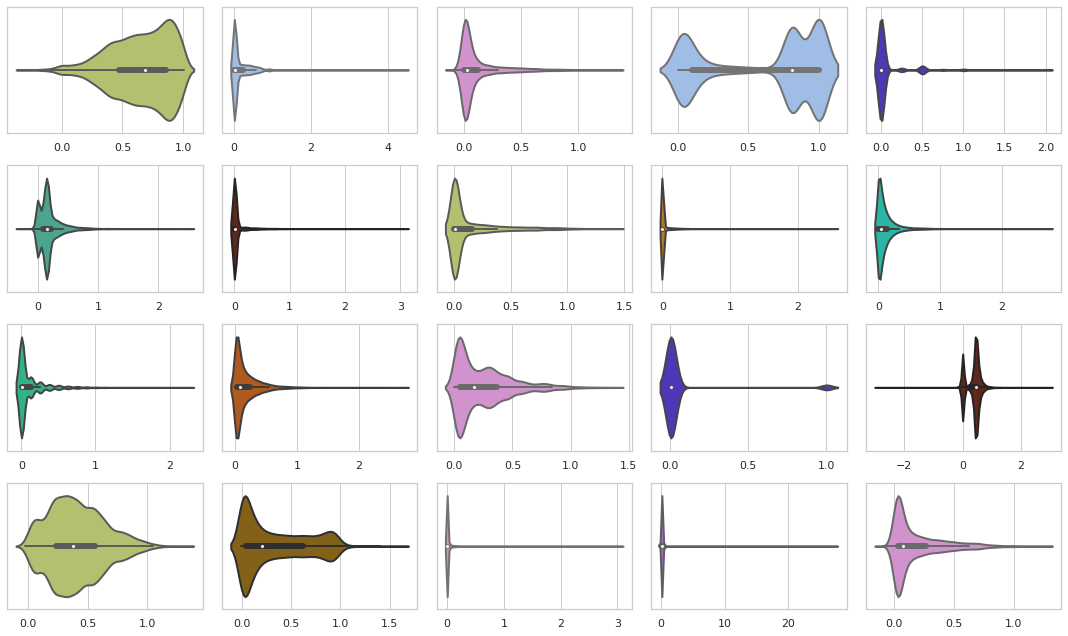

In [ ]:
np.random.seed(0)
sns.set_theme(style="whitegrid")

number_of_colors = len(sel_feat_expl)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

cols = 5
rows = 4
num_cols = sel_feat_expl
fig = plt.figure(figsize= (15,9))
for i, col in enumerate(num_cols):
    
    ax=fig.add_subplot( rows, cols, i+1)
    
    sns.violinplot(x=[row[col] for row in df.select(col).collect()], ax=ax, color = random.choice(color), linewidth=2)
    
fig.tight_layout()  
plt.show()

In [ ]:
#Initializing univariate feature selection metrics dict
univariate_metrics_dict = dict()

In [ ]:
def classreport():
    """
    returning y_test and y_pred lists
    """
    
    liste = predictions.select(['label', 'prediction']).collect()
    y_test = [row.label for row in liste]
    y_pred = [row.prediction for row in liste]
    return y_test, y_pred

### Train-test split

In [ ]:
train, validation = result.randomSplit(weights=[0.8,0.2], seed=42)

#Renaming columns due to some incompatibility
train = train.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation = validation.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

### Decision Tree

In [ ]:
# training
model_dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model_dt = model_dt.fit(train)
# predictions
predictions = model_dt.transform(validation)

In [ ]:
dt_univariate_matrics = compute_metrics()
dt_univariate_matrics

{'f1': 0.8383945915690815,
 'accuracy': 0.8397932816537468,
 'recallByLabel': 0.6520833333333333,
 'precisionByLabel': 0.6864035087719298}

In [ ]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      1455
         1.0       0.69      0.65      0.67       480

    accuracy                           0.84      1935
   macro avg       0.79      0.78      0.78      1935
weighted avg       0.84      0.84      0.84      1935



### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42, numTrees=30)
model = rf.fit(train)

In [ ]:
rf_feat_imp = model.featureImportances

In [ ]:
feat_by_imp = sorted(list(zip(rf_feat_imp.indices, rf_feat_imp.toArray())), key = lambda x: -x[1])

correct_feat_by_imp = [(sel_feat_expl[tup[0]], tup[1]) for tup in feat_by_imp]
correct_feat_by_imp

[('P_2', 0.2867452834090826),
 ('D_48', 0.19198198840192904),
 ('D_44', 0.12631356198862848),
 ('B_7', 0.06736539209661986),
 ('B_1', 0.06587141193048551),
 ('B_3', 0.059210995363637324),
 ('D_45', 0.03593696913356578),
 ('B_6', 0.027422286817286333),
 ('D_42', 0.023944825776984993),
 ('R_1', 0.023001727439980257),
 ('B_2', 0.019997521229649717),
 ('S_3', 0.019818537227191447),
 ('B_4', 0.01644681716625588),
 ('D_47', 0.015400053129818654),
 ('D_43', 0.009563546520081002),
 ('D_41', 0.004022928392295628),
 ('R_2', 0.0025305444197740467),
 ('D_39', 0.0016769989901683747),
 ('D_46', 0.0016189957479494537),
 ('D_49', 0.0011296148186158259)]

In [ ]:
predictions = model.transform(validation)

In [ ]:
predictions.show(5)

+--------------------+----------+-----+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|label|            features|       rawPrediction|         probability|prediction|
+--------------------+----------+-----+--------------------+--------------------+--------------------+----------+
|001cde1044b029fab...|2017-03-25|  1.0|[0.0,0.033,0.899,...|[17.5251991410550...|[0.58417330470183...|       0.0|
|003f7b33280fff053...|2017-11-22|  1.0|[0.528,0.008,0.00...|[22.1281182823531...|[0.73760394274510...|       0.0|
|005382536094338c2...|2017-09-16|  0.0|[0.281,0.031,0.04...|[24.5349586297951...|[0.81783195432650...|       0.0|
|0081622f92bc7b661...|2018-02-10|  0.0|[0.911,0.068,0.01...|[29.1650472085114...|[0.97216824028371...|       0.0|
|00be9aec004505277...|2017-03-22|  0.0|[0.608,0.004,0.03...|[23.9430346069989...|[0.79810115356663...|       0.0|
+--------------------+----------+-----+--------------------+--------------------+-------

In [ ]:
rf_univariate_metrics = compute_metrics()

In [ ]:
from sklearn.metrics import classification_report as cr

liste = predictions.select(['label', 'prediction']).collect()

y_test = [row.label for row in liste]
y_pred = [row.prediction for row in liste]

print(cr(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1455
         1.0       0.72      0.64      0.67       480

    accuracy                           0.85      1935
   macro avg       0.80      0.78      0.79      1935
weighted avg       0.84      0.85      0.84      1935



### Gradient Boosted Tree 

GBTs iteratively train decision trees in order to minimize a loss function.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer


labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(train)
featureIndexer =  VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(train)

In [ ]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=5)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

In [ ]:
model = pipeline.fit(train)
predictions = model.transform(validation)

In [ ]:
predictions.show(5)

+--------------------+----------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|label|            features|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|
+--------------------+----------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|001cde1044b029fab...|2017-03-25|  1.0|[0.0,0.033,0.899,...|         1.0|[0.0,0.033,0.899,...|[-0.3749691260909...|[0.32083475551388...|       1.0|
|003f7b33280fff053...|2017-11-22|  1.0|[0.528,0.008,0.00...|         1.0|[0.528,0.008,0.00...|[0.40234122715626...|[0.69097521148361...|       0.0|
|005382536094338c2...|2017-09-16|  0.0|[0.281,0.031,0.04...|         0.0|[0.281,0.031,0.04...|[0.66239811986213...|[0.78997856906150...|       0.0|
|0081622f92bc7b661...|2018-02-10|  0.0|[0.911,0.068,0.01...|         0.0|[0.911,0.068,0.01...|[1.13673249034452.

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.154005


In [ ]:
gbt_univariate_results = compute_metrics()

### SVM


In [ ]:
lsvc = LinearSVC(maxIter=10)
c_values = [10, 1, 0.1, 0.01, 0.001, 0.0001]
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, c_values).build()

In [ ]:
tvs = TrainValidationSplit(estimator=lsvc, 
                           estimatorParamMaps=paramGrid, 
                           trainRatio=0.8, evaluator=MulticlassClassificationEvaluator(metricName = 'accuracy'))

model_tvs = tvs.fit(train)

In [ ]:
# Check the validation accuracy over each C value 
print("Validation accuracies: ")
list(zip(model_tvs.validationMetrics, c_values))

Validation accuracies: 


[(0.7395898073337477, 10),
 (0.8253573648228714, 1),
 (0.8495960223741454, 0.1),
 (0.8539465506525793, 0.01),
 (0.8539465506525793, 0.001),
 (0.853325046612803, 0.0001)]

In [ ]:
# Make predictions on test data. 
predictions = model_tvs.transform(validation)
    
# Define the evaluator method with the corresponding metric and compute the classification error on test data
evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions) 

# Show the accuracy
print("Test accuracy = %g" % (accuracy))

Test accuracy = 0.85168


In [ ]:
svm_univariate_metrics = compute_metrics()

In [ ]:
#Uploading results to univariate dict
univariate_metrics_dict.update({"dt": dt_univariate_matrics,
                                "rf": rf_univariate_metrics,
                                "gbt": gbt_univariate_results,
                                "svm": svm_univariate_metrics})

univariate_metrics_dict

{'dt': {'f1': 0.8383945915690815,
  'accuracy': 0.8397932816537468,
  'recallByLabel': 0.6520833333333333,
  'precisionByLabel': 0.6864035087719298},
 'rf': {'f1': 0.8447903154874403,
  'accuracy': 0.8480620155038759,
  'recallByLabel': 0.6354166666666666,
  'precisionByLabel': 0.7193396226415094},
 'gbt': {'f1': 0.8439356998064903,
  'accuracy': 0.8459948320413436,
  'recallByLabel': 0.6520833333333333,
  'precisionByLabel': 0.704954954954955},
 'svm': {'f1': 0.8479139568000774,
  'accuracy': 0.8516795865633074,
  'recallByLabel': 0.6333333333333333,
  'precisionByLabel': 0.7325301204819277}}

## Feature Selection Univariate - NO Outliers

### Removing Outliers

In [ ]:
bounds = {col:dict(zip(["q1", "q3"], df.select(sel_feat_expl).approxQuantile(col, [0.25, 0.75], 0))) for col in sel_feat_expl}

In [ ]:
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['min'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['max'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)

{'P_2': {'q1': 0.473, 'q3': 0.859, 'lower': -0.10599999999999998, 'upper': 1.438, 'min': -0.10599999999999998, 'max': 1.438}, 'D_39': {'q1': 0.004, 'q3': 0.235, 'lower': -0.34249999999999997, 'upper': 0.5814999999999999, 'min': -0.34249999999999997, 'max': 0.5814999999999999}, 'B_1': {'q1': 0.008, 'q3': 0.126, 'lower': -0.16899999999999998, 'upper': 0.303, 'min': -0.16899999999999998, 'max': 0.303}, 'B_2': {'q1': 0.102, 'q3': 1.002, 'lower': -1.248, 'upper': 2.3520000000000003, 'min': -1.248, 'max': 2.3520000000000003}, 'R_1': {'q1': 0.002, 'q3': 0.008, 'lower': -0.007000000000000001, 'upper': 0.017, 'min': -0.007000000000000001, 'max': 0.017}, 'S_3': {'q1': 0.083, 'q3': 0.217, 'lower': -0.11800000000000001, 'upper': 0.41800000000000004, 'min': -0.11800000000000001, 'max': 0.41800000000000004}, 'D_41': {'q1': 0.002, 'q3': 0.008, 'lower': -0.007000000000000001, 'upper': 0.017, 'min': -0.007000000000000001, 'max': 0.017}, 'B_3': {'q1': 0.005, 'q3': 0.156, 'lower': -0.22149999999999997, '

In [ ]:
#Adding columns saying if a record is an outlier w.r.t. the column itself

import pyspark.sql.functions as f
df_outliers = df.select("*", *[ f.when( f.col(c).between(bounds[c]['min'], 
                                           bounds[c]['max']), 0).otherwise(1).alias(c+"_out") for c in sel_feat_expl])

df_outliers.select([col+"_out" for col in sel_feat_expl]).show(5)

+-------+--------+-------+-------+-------+-------+--------+-------+--------+--------+--------+-------+--------+-------+--------+--------+--------+--------+-------+-------+
|P_2_out|D_39_out|B_1_out|B_2_out|R_1_out|S_3_out|D_41_out|B_3_out|D_42_out|D_43_out|D_44_out|B_4_out|D_45_out|R_2_out|D_46_out|D_47_out|D_48_out|D_49_out|B_6_out|B_7_out|
+-------+--------+-------+-------+-------+-------+--------+-------+--------+--------+--------+-------+--------+-------+--------+--------+--------+--------+-------+-------+
|      0|       0|      0|      0|      1|      0|       0|      0|       0|       0|       0|      0|       0|      0|       0|       1|       0|       0|      0|      0|
|      0|       0|      0|      0|      0|      0|       0|      0|       0|       0|       0|      0|       0|      0|       0|       0|       0|       0|      0|      0|
|      0|       0|      0|      0|      0|      0|       0|      0|       0|       0|       0|      0|       0|      0|       0|       0|   

In [ ]:
#Dataframe with new Outlier column; 0 == No Outlier / 1 == Outlier
df_outliers = df_outliers.withColumn("outlier", sum(df_outliers[col+"_out"] for col in sel_feat_expl))
df_outliers.select(["customer_ID", "outlier"]).show(5)

+--------------------+-------+
|         customer_ID|outlier|
+--------------------+-------+
|02c0a620752ad66f7...|      2|
|035d414d0be243367...|      0|
|1189cc2b6a77402e9...|      0|
|1320d713d54534d09...|      3|
|13252c0f67bd62ede...|      4|
+--------------------+-------+
only showing top 5 rows



In [ ]:
#Dataframe with no outliers
df_no_outliers = df_outliers.where('outlier < 3')
print(f"No Outlier dataset count: {df_no_outliers.count()}")
df_no_outliers.select(["customer_ID", "outlier"]).show(5)

No Outlier dataset count: 7819
+--------------------+-------+
|         customer_ID|outlier|
+--------------------+-------+
|02c0a620752ad66f7...|      2|
|035d414d0be243367...|      0|
|1189cc2b6a77402e9...|      0|
|21a61f9d745300f33...|      0|
|3db3161fbf9c93e4e...|      0|
+--------------------+-------+
only showing top 5 rows



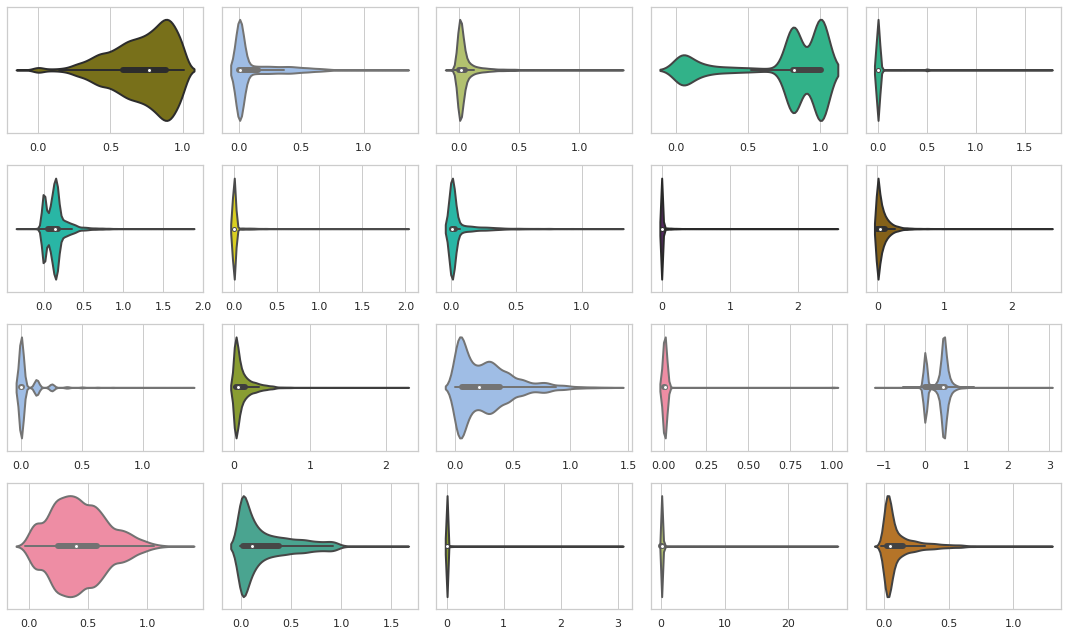

In [ ]:
np.random.seed(0)
sns.set_theme(style="whitegrid")

cols = 5
rows = 4
num_cols = sel_feat_expl
fig = plt.figure(figsize= (15,9))
for i, col in enumerate(num_cols):
    
    ax=fig.add_subplot( rows, cols, i+1)
    
    sns.violinplot(x=[row[col] for row in df_no_outliers.select(col).collect()], ax=ax, color = random.choice(color), linewidth=2)
    
fig.tight_layout()  
plt.show()

In [ ]:
df_no_outliers.show(5)

+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
#Vectorizing features
vecAssembler = VectorAssembler(inputCols=sel_feat_expl, outputCol="features")
assembled_df_no_outlier = vecAssembler.transform(df_no_outliers).select(['customer_ID', 'S_2', 'target']+['features'])

assembled_df_no_outlier.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|02c0a620752ad66f7...|2017-07-02|   0.0|[0.445,0.421,0.01...|
|035d414d0be243367...|2017-06-28|   0.0|[0.967,0.007,-0.0...|
|1189cc2b6a77402e9...|2017-11-25|   0.0|[0.945,0.007,0.00...|
|21a61f9d745300f33...|2018-03-02|   0.0|[0.842,0.004,0.01...|
|3db3161fbf9c93e4e...|2018-02-21|   0.0|[0.849,0.004,0.00...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



In [ ]:
assembled_df_no_outlier.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|   0.0| 6765|
|   1.0| 1054|
+------+-----+



In [ ]:
df.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|   0.0| 7462|
|   1.0| 2539|
+------+-----+



### Train Val split

In [ ]:
train, validation = assembled_df_no_outlier.randomSplit(weights=[0.80,0.20], seed=0)

train = train.sampleBy("target", fractions = {1.0 : .85,
                                              0.0 : .15}, seed= 0)

validation = validation.sampleBy("target", fractions = {1.0 : .85,
                                              0.0 : .15}, seed= 0)

#Renaming columns due to some incompatibility
train = train.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation = validation.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

In [ ]:
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  784|
|  1.0|  707|
+-----+-----+



In [ ]:
validation.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  233|
|  1.0|  191|
+-----+-----+



In [ ]:
univariate_no_outliers_metrics_dict = dict()

### Decision Tree

In [ ]:
# training
model_dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model_dt = model_dt.fit(train)
# predictions
predictions = model_dt.transform(validation)

In [ ]:
dt_univariate_no_outliers_matrics = compute_metrics()
dt_univariate_no_outliers_matrics

{'f1': 0.8043726885042284,
 'accuracy': 0.8042452830188679,
 'recallByLabel': 0.8848167539267016,
 'precisionByLabel': 0.7347826086956522}

In [ ]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.89      0.74      0.81       233
         1.0       0.73      0.88      0.80       191

    accuracy                           0.80       424
   macro avg       0.81      0.81      0.80       424
weighted avg       0.82      0.80      0.80       424



### Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42, numTrees=30)
model = rf.fit(train)
predictions = model.transform(validation)

In [ ]:
rf_univariate_no_outliers_metrics = compute_metrics()

In [ ]:
liste = predictions.select(['label', 'prediction']).collect()

y_test = [row.label for row in liste]
y_pred = [row.prediction for row in liste]

print(cr(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       233
         1.0       0.76      0.86      0.81       191

    accuracy                           0.82       424
   macro avg       0.82      0.82      0.82       424
weighted avg       0.82      0.82      0.82       424



### SVM

In [ ]:
lsvc = LinearSVC(maxIter=10)
c_values = [10, 1, 0.1, 0.01, 0.001, 0.0001]
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, c_values).build()

In [ ]:
tvs = TrainValidationSplit(estimator=lsvc, 
                           estimatorParamMaps=paramGrid, 
                           trainRatio=0.8, evaluator=MulticlassClassificationEvaluator(metricName = 'accuracy'))

model_tvs = tvs.fit(train)

In [ ]:
# Check the validation accuracy over each C value 
print("Validation accuracies: ")
list(zip(model_tvs.validationMetrics, c_values))

Validation accuracies: 


[(0.49834983498349833, 10),
 (0.7821782178217822, 1),
 (0.7854785478547854, 0.1),
 (0.7887788778877888, 0.01),
 (0.7920792079207921, 0.001),
 (0.7920792079207921, 0.0001)]

In [ ]:
svm_univariate_no_outliers_metrics = compute_metrics()

### Gradient Boosting Trees

In [ ]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(train)
featureIndexer =  VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(train)

In [ ]:
model = pipeline.fit(train)
predictions = model.transform(validation)

In [ ]:
gbt_univariate_no_outliers_results = compute_metrics()
gbt_univariate_no_outliers_results

{'f1': 0.8211710544335937,
 'accuracy': 0.8207547169811321,
 'recallByLabel': 0.8429319371727748,
 'precisionByLabel': 0.7777777777777778}

In [ ]:
liste = predictions.select(['label', 'prediction']).collect()
y_test = [row.label for row in liste]
y_pred = [row.prediction for row in liste]

print(cr(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       233
         1.0       0.78      0.84      0.81       191

    accuracy                           0.82       424
   macro avg       0.82      0.82      0.82       424
weighted avg       0.82      0.82      0.82       424



In [ ]:
#Uploading results to univariate dict
univariate_no_outliers_metrics_dict.update({"dt": dt_univariate_no_outliers_matrics,
                                            "rf": rf_univariate_no_outliers_metrics,
                                            "gbt": gbt_univariate_no_outliers_results,
                                            "svm": svm_univariate_no_outliers_metrics})

univariate_no_outliers_metrics_dict

{'dt': {'f1': 0.8043726885042284,
  'accuracy': 0.8042452830188679,
  'recallByLabel': 0.8848167539267016,
  'precisionByLabel': 0.7347826086956522},
 'rf': {'f1': 0.8188262386375593,
  'accuracy': 0.8183962264150944,
  'recallByLabel': 0.8638743455497382,
  'precisionByLabel': 0.7638888888888888},
 'gbt': {'f1': 0.8211710544335937,
  'accuracy': 0.8207547169811321,
  'recallByLabel': 0.8429319371727748,
  'precisionByLabel': 0.7777777777777778},
 'svm': {'f1': 0.8188262386375593,
  'accuracy': 0.8183962264150944,
  'recallByLabel': 0.8638743455497382,
  'precisionByLabel': 0.7638888888888888}}

## Classification Dict

In [ ]:
classification_dict = {"variance Treshold" : varianceT_metrics_dict,
                       "univariate" : univariate_metrics_dict,
                       "univariate No Outliers" : univariate_no_outliers_metrics_dict}

classification_dict

{'variance Treshold': {'dt': {'f1': 0.7502258317686978,
   'accuracy': 0.786046511627907,
   'recallByLabel': 0.2708333333333333,
   'precisionByLabel': 0.6701030927835051},
  'rf': {'f1': 0.7349810101221226,
   'accuracy': 0.7844961240310078,
   'recallByLabel': 0.20416666666666666,
   'precisionByLabel': 0.7368421052631579},
  'gbt': {'f1': 0.7663923578537911,
   'accuracy': 0.7917312661498708,
   'recallByLabel': 0.33958333333333335,
   'precisionByLabel': 0.6546184738955824},
  'svm': {'f1': 0.6483426083733964,
   'accuracy': 0.751937984496124,
   'recallByLabel': 0.00625,
   'precisionByLabel': 0.5}},
 'univariate': {'dt': {'f1': 0.8383945915690815,
   'accuracy': 0.8397932816537468,
   'recallByLabel': 0.6520833333333333,
   'precisionByLabel': 0.6864035087719298},
  'rf': {'f1': 0.8447903154874403,
   'accuracy': 0.8480620155038759,
   'recallByLabel': 0.6354166666666666,
   'precisionByLabel': 0.7193396226415094},
  'gbt': {'f1': 0.8439356998064903,
   'accuracy': 0.84599483204

# PCA

In [ ]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(assembled_df)
pca_df = model.transform(assembled_df)

In [ ]:
pca_df.show(5)

+--------------------+----------+------+--------------------+--------------------+
|         customer_ID|       S_2|target|            features|        pca_features|
+--------------------+----------+------+--------------------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|[0.00326475286152...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.96,0.006,0.001...|[0.00385749576992...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|[0.00937803901764...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|[0.01962854750359...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.829,1.037,0.04...|[0.00516078085079...|
+--------------------+----------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
sampled_pca_out = pca_df.sample(withReplacement = False, fraction = 0.99, seed = 42)
data_pca_collected = sampled_pca_out.select('pca_features').collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])

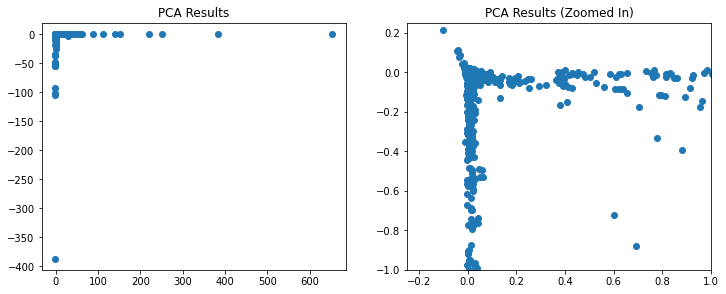

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1])

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1])
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.show()

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(assembled_df.select('features'))

# Make predictions
predictions = model.transform(assembled_df.select('features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

In [ ]:
cluster_pca = pca_df.join(predictions, 'features')

In [ ]:
sampled_pca_out = cluster_pca.sample(withReplacement = False, fraction = 0.99, seed = 42)
data_pca_collected = sampled_pca_out.select(['pca_features', 'prediction', 'target']).collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])
colors = np.array([row.prediction for row in data_pca_collected])
colors_true = np.array([row.target for row in data_pca_collected])

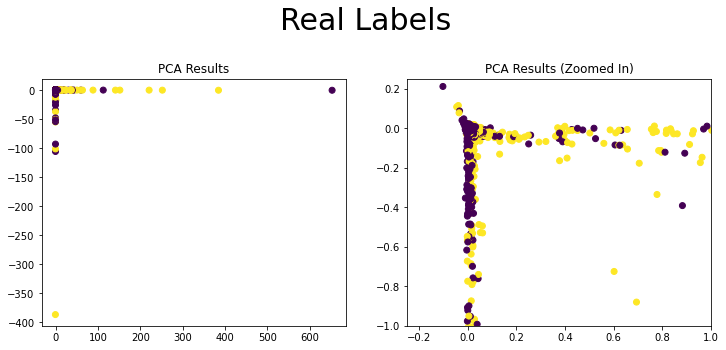

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Real Labels', fontsize = 30)
plt.show()


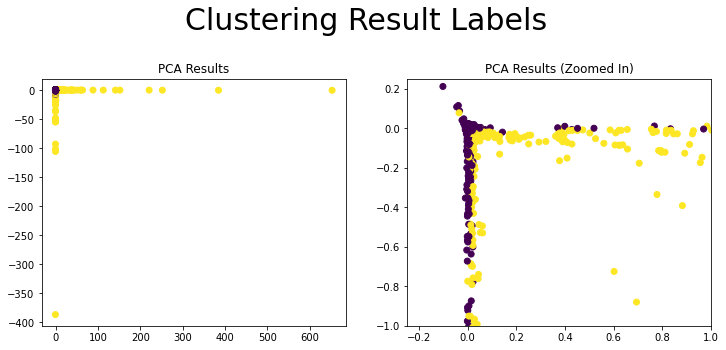

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Clustering Result Labels', fontsize = 30)
plt.show()


# Geographic Representation

## Importing US geometries

In [ ]:
from lemma_dev_utils import download_unzip, download 
import geopandas as gpd
import pandas as pd
import numpy as np
import codecs

In [ ]:
# counties = download("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_500k.json")

In [ ]:
#creating a gpd from the file of the counties
with codecs.open("/content/drive/Shareddrives/Mie Robe/gz_2010_us_050_00_500k.json", 'r', encoding='utf-8', errors='ignore') as f:
    counties_gpd = gpd.read_file(f)

# counties_gpd['wkt'] = pd.Series(map(lambda geom: str(geom.wkt), counties_gpd['geometry']), index=counties_gpd.index, dtype='string')
counties_gpd.head()

GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0  0500000US01029    01    029   Cleburne  County     560.100   
1  0500000US01031    01    031     Coffee  County     678.972   
2  0500000US01037    01    037      Coosa  County     650.926   
3  0500000US01039    01    039  Covington  County    1030.456   
4  0500000US01041    01    041   Crenshaw  County     608.840   

                                            geometry  
0  POLYGON ((-85.38872 33.91304, -85.38089 33.873...  
1  POLYGON ((-86.03044 31.61894, -86.00409 31.619...  
2  POLYGON ((-86.00928 33.10164, -86.00917 33.090...  
3  POLYGON ((-86.34851 30.99434, -86.35023 30.994...  
4  POLYGON ((-86.14699 31.68045, -86.14711 31.663...

In [ ]:
US_geometry = counties_gpd["geometry"].unary_union
US_geometry

### Creating Lat/Lon Maps

In [ ]:
from skmob.utils.plot import plot_gdf

In [ ]:
counties_gpd['nation'] = ['USA'] * len(counties_gpd)

US_union = counties_gpd.dissolve(by='nation')

US_geometries = [x for x in US_union['geometry'][0].geoms]

max_idx = np.argmax([x.area for x in US_geometries])

US_geometry = US_geometries[max_idx]

In [ ]:
plot_gdf(gpd.GeoDataFrame(geometry=[US_geometry]))

In [ ]:
plot_gdf(counties_gpd.dissolve(by='STATE')) 

### Mapping customer_IDs with random geoIDs

In [ ]:
n_rows = 10001
geo_ids = counties_gpd['GEO_ID'].values

In [ ]:
np.random.seed(42)
# mapping each position with a lat/lon array
rdd_latlon = df.select('customer_ID').distinct().rdd.map(lambda x: (x.customer_ID, np.random.choice(geo_ids)))

In [ ]:
#converting rdd to df
latlon_df = rdd_latlon.toDF() #to get stringType without importing it
for old_col, new_col in zip(latlon_df.columns, ['customer_ID', 'GEO_ID']):
    latlon_df = latlon_df.withColumnRenamed(old_col, new_col)
latlon_df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- GEO_ID: string (nullable = true)



In [ ]:
latlon_df.show(5)

+--------------------+--------------+
|         customer_ID|        GEO_ID|
+--------------------+--------------+
|02c0a620752ad66f7...|0500000US46065|
|035d414d0be243367...|0500000US48067|
|1189cc2b6a77402e9...|0500000US25001|
|1320d713d54534d09...|0500000US72071|
|13252c0f67bd62ede...|0500000US26129|
|18654c06ae5e23397...|0500000US29039|
|193076b7a6c019284...|0500000US18071|
|21a61f9d745300f33...|0500000US08081|
|3db3161fbf9c93e4e...|0500000US37199|
|3f4022008525be955...|0500000US27043|
|415a0bd6469799bfb...|0500000US38049|
|46d3a4b20ea2eb18f...|0500000US28101|
|52781d3c05a7d0ec0...|0500000US48073|
|56c5c93e2882df966...|0500000US20001|
|5867da5e559b68f58...|0500000US01123|
|586e62618727d32a4...|0500000US18071|
|6526d537d27650096...|0500000US12029|
|653c07f35a788f9b3...|0500000US51059|
|6f9db50e73212a649...|0500000US29019|
|7cabe216eaff8099f...|0500000US32510|
+--------------------+--------------+
only showing top 20 rows



### Joining tables

Each customer_ID has it's own GeoID, even tho the customer is repreated

In [ ]:
union_df = df.join(latlon_df, on = 'customer_ID')

In [ ]:
union_df.select('customer_ID').distinct().count()

9896

In [ ]:
union_df.select(['customer_ID', 'GEO_ID']).distinct().count()

9896

In [ ]:
union_df.show()

+--------------------+----------+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--

In [ ]:
# overall columns
cols = union_df.columns

#D_* starting columns
d_columns = [col for col in cols if col[0].lower() == "d"]
d_columns[:5]

['D_39', 'D_41', 'D_42', 'D_43', 'D_44']

In [ ]:
# Extragning column Variance from "D_*" columns
variances = df.agg({ col : "variance" for col in d_columns}).collect()
d_var = list(variances[0].asDict().items())

#dropping None Values as variance
d_variances = [(k,v) for k, v in d_var if v is not None]
d_variances[:5]

[('variance(D_74)', 0.049932474870232946),
 ('variance(D_55)', 0.08469521938432152),
 ('variance(D_70)', 0.05057746768033199),
 ('variance(D_81)', 0.12661898251030876),
 ('variance(D_92)', 0.0852443522150584)]

In [ ]:
#Extracting Maximum Variance Column
key_max = sorted(d_variances, key=lambda x: -x[1])[0]

max_variance_column = "D_39"                            #re.findall("D_[1-9]{1,3}",key_max[0])[0]
print("Maximum_Variance_column:", max_variance_column)

Maximum_Variance_column: D_39


In [ ]:
#Calculating Column Median
median = union_df.approxQuantile(max_variance_column, [0.5], 0.1)[0]
print("Median:", median)

#Filtering for rows above median value
filtered_df = union_df.filter(f'{max_variance_column} > {median}')
filtered_df.show()

Median: 0.007
+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---

In [ ]:
from math import exp, e
from pyspark.sql.functions import col, lit

#Sintetizing new exponential column
filtered_df = filtered_df.withColumn("new_D_col", e**(col(max_variance_column)+10))

In [ ]:
#Sampling the data frame as a good spark manner
sample_filtered_df = filtered_df.sample(withReplacement = False, fraction = 0.99, seed = 42)

# Filtering for the columns we want and making the df a Pandas Object to work on
to_plot_df = sample_filtered_df.select(['customer_ID', 'new_D_col', 'GEO_ID'])
to_plot_pdf = to_plot_df.toPandas()

#merging the df with original geopandas df by "GEO_ID" key
to_plot_pdf = to_plot_pdf.merge(counties_gpd, on = 'GEO_ID')

#Dissolving geometry by STATE dimension
to_plot_gdf = gpd.GeoDataFrame(
                    to_plot_pdf[['customer_ID', 'STATE', 'new_D_col']]\
                    .merge(counties_gpd.dissolve(by='STATE').reset_index()[['geometry', 'STATE']], on='STATE')
                    )

to_plot_gdf.head()

customer_ID STATE     new_D_col  \
0  02c0a620752ad66f76851a1f063aa47d9c37ef3680062f...    36  33556.974347   
1  521d06025a10a67a2fc5b35a45927bd7d365b0f5134f44...    36  22203.384251   
2  a177b8ee96f4cd298ef28a9253a54c1387fb921fd36786...    36  24934.308862   
3  fed9b819ff7c9dd91f1959e1a2af3907a0ba043e06dd4f...    36  29673.213041   
4  c5ea0a292442ad3d9b6ac14d95d28c4a4a5a9558708352...    36  41068.636213   

                                            geometry  
0  MULTIPOLYGON (((-76.13120 41.99895, -76.20493 ...  
1  MULTIPOLYGON (((-76.13120 41.99895, -76.20493 ...  
2  MULTIPOLYGON (((-76.13120 41.99895, -76.20493 ...  
3  MULTIPOLYGON (((-76.13120 41.99895, -76.20493 ...  
4  MULTIPOLYGON (((-76.13120 41.99895, -76.20493 ...

In [ ]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

aggregated_by_state = to_plot_gdf.groupby('STATE').agg(list).reset_index()

In [ ]:
aggregated_by_state['geometry'] = aggregated_by_state['geometry'].map(lambda x: x[0])

In [ ]:
aggregated_by_state = gpd.GeoDataFrame(aggregated_by_state[['STATE', 'geometry']])

In [ ]:
path = os.getcwd()+'/for_choropleth.geojson'
aggregated_by_state.to_file(path, driver="GeoJSON")

In [ ]:
aggregated_by_state.head()

STATE                                           geometry
0    01  MULTIPOLYGON (((-88.07485 30.24912, -88.07586 ...
1    02  MULTIPOLYGON (((-179.09466 51.30123, -179.0754...
2    04  POLYGON ((-112.56252 31.80188, -112.60779 31.8...
3    05  POLYGON ((-93.39593 33.01831, -93.46704 33.018...
4    06  MULTIPOLYGON (((-122.33321 37.59146, -122.3176...

In [ ]:
import folium

custom_scale = (to_plot_gdf['new_D_col'].quantile((0,0.2,0.4,0.6,0.8,0.9,1))).tolist()

us_map = folium.Map(loc=(US_geometry.centroid.y, US_geometry.centroid.x), tiles='Stamen Toner', zoom_start=13)

folium.Choropleth(
            geo_data=path,
            data=to_plot_gdf,
            columns=['STATE', 'new_D_col'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.STATE', #use the custom scale we created for legend
            fill_color='YlOrBr',
            fill_opacity = 0.7,
            line_opacity = 0.2,
            legend_name="Delinquency Rate").add_to(us_map) 

folium.ClickForMarker()

In [ ]:
us_map

In [ ]:
len(to_plot_gdf["D_39"])

6051